In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from math import floor, ceil
from pylab import rcParams

%matplotlib inline

/opt/ds/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
sns.set(style='ticks', palette='Spectral', font_scale=1.5)
material_palette = ["#4CAF50", "#2196F3", "#9E9E9E", "#FF9800", "#607D8B", "#9C27B0"]
sns.set_palette(material_palette)
rcParams['figure.figsize'] = 16, 8
plt.xkcd();
random_state = 42
np.random.seed(random_state)
tf.set_random_seed(random_state)

/opt/ds/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [15]:
math_df = pd.read_csv("data/NonLinearClassification/student-mat.csv", sep=",")
port_df = pd.read_csv("data/NonLinearClassification/student-por.csv", sep=",")

math_df["course"] = "math"
port_df["course"] = "portuguese"

merged_df = math_df.append(port_df)
merged_df.shape

(1044, 34)

In [16]:
merged_df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,course
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,3,4,1,1,3,6,5,6,6,math
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,3,3,1,1,3,4,5,5,6,math
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,3,2,2,3,3,10,7,8,10,math
3,GP,F,15,U,GT3,T,4,2,health,services,...,2,2,1,1,5,2,15,14,15,math
4,GP,F,16,U,GT3,T,3,3,other,other,...,3,2,1,2,5,4,6,10,10,math


In [17]:
merge_vector = ["school","sex","age","address",
                "famsize","Pstatus","Medu","Fedu",
                "Mjob","Fjob","reason","nursery","internet"]

duplicated_mask = merged_df.duplicated(keep=False, subset=merge_vector)
duplicated_df = merged_df[duplicated_mask]
unique_df = merged_df[~duplicated_mask]
both_courses_mask = duplicated_df.duplicated(subset=merge_vector)
both_courses_df = duplicated_df[~both_courses_mask].copy()
both_courses_df["course"] = "both"
students_df = unique_df.append(both_courses_df)

students_df.head()

In [18]:
students_df = students_df.sample(frac=1)
#We will use the following formula to quantify the amount of alcohol taken during the week per student:
students_df['alcohol'] = (students_df.Walc * 2 + students_df.Dalc * 5) / 7
students_df['alcohol'] = students_df.alcohol.map(lambda x: ceil(x))
students_df['drinker'] = students_df.alcohol.map(lambda x: "yes" if x > 2 else "no")

/opt/ds/lib/python3.4/site-packages/matplotlib/font_manager.py:1287: UserWarning: findfont: Font family ['Humor Sans', 'Comic Sans MS'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


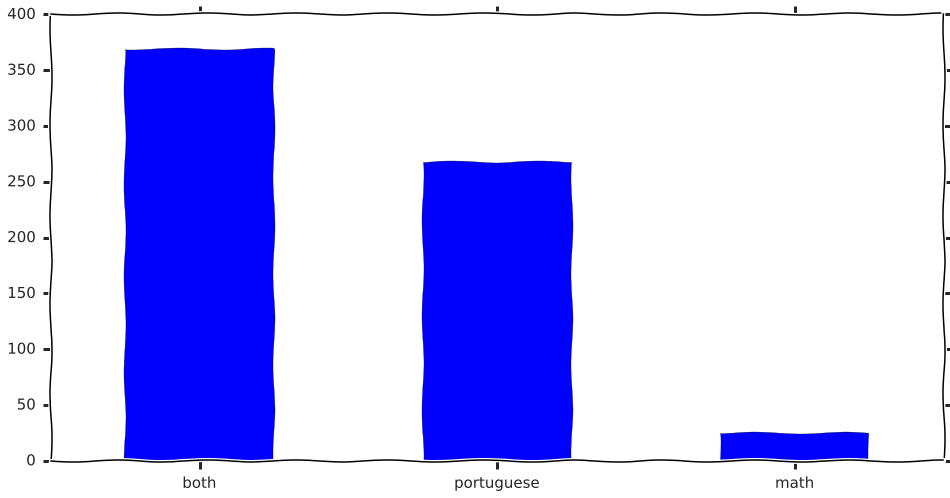

In [19]:
students_df.course.value_counts().plot(kind="bar", rot=0);

/opt/ds/lib/python3.4/site-packages/matplotlib/font_manager.py:1287: UserWarning: findfont: Font family ['Humor Sans', 'Comic Sans MS'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


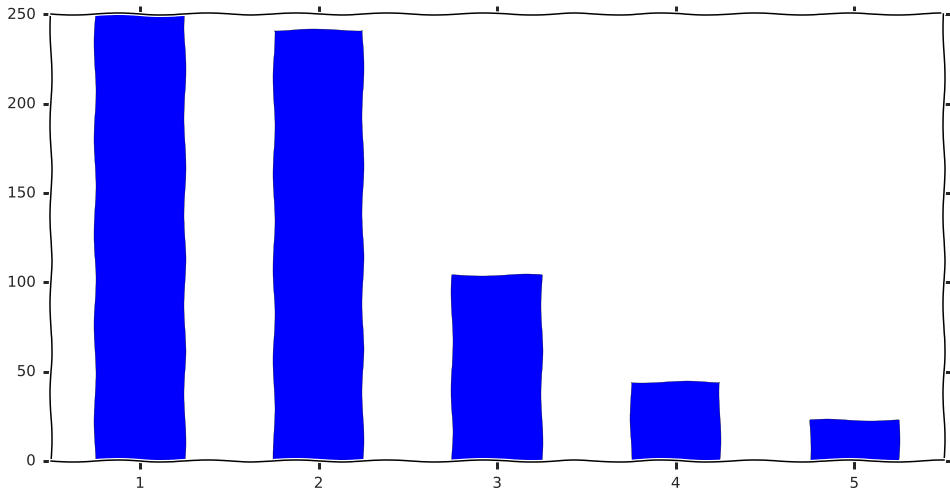

In [20]:
students_df.alcohol.value_counts().plot(kind="bar", rot=0);

/opt/ds/lib/python3.4/site-packages/matplotlib/font_manager.py:1287: UserWarning: findfont: Font family ['Humor Sans', 'Comic Sans MS'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


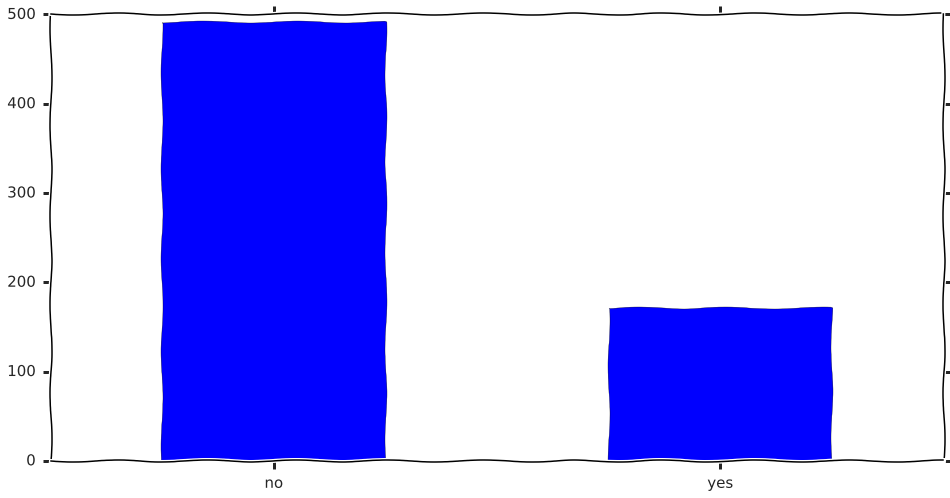

In [21]:
students_df.drinker.value_counts().plot(kind="bar", rot=0);

/opt/ds/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/opt/ds/lib/python3.4/site-packages/matplotlib/font_manager.py:1287: UserWarning: findfont: Font family ['Humor Sans', 'Comic Sans MS'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


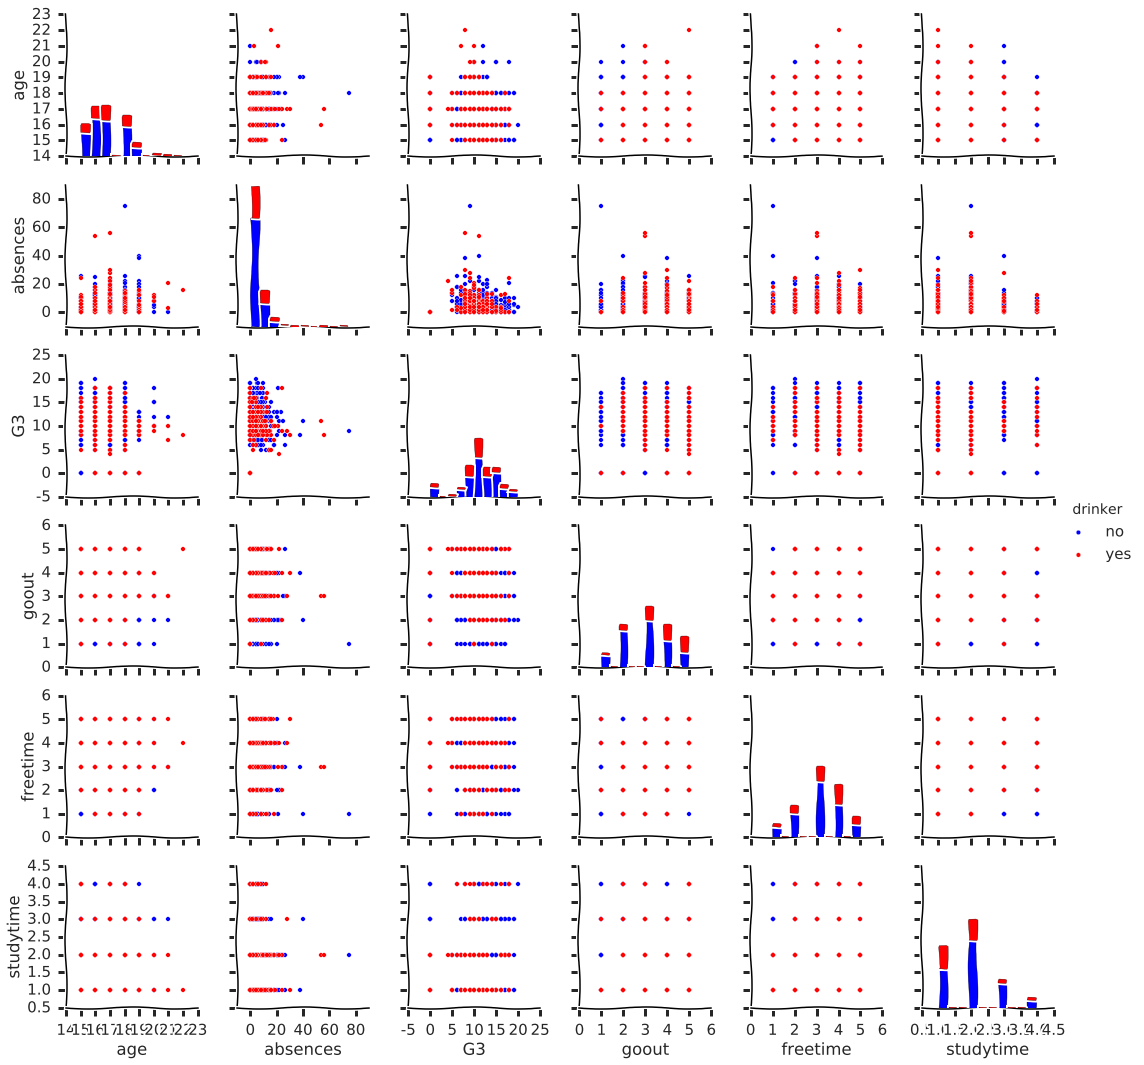

In [22]:
sns.pairplot(students_df[['age', 'absences', 'G3', 'goout', 'freetime', 'studytime', 'drinker']], hue='drinker');

/opt/ds/lib/python3.4/site-packages/matplotlib/font_manager.py:1287: UserWarning: findfont: Font family ['Humor Sans', 'Comic Sans MS'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


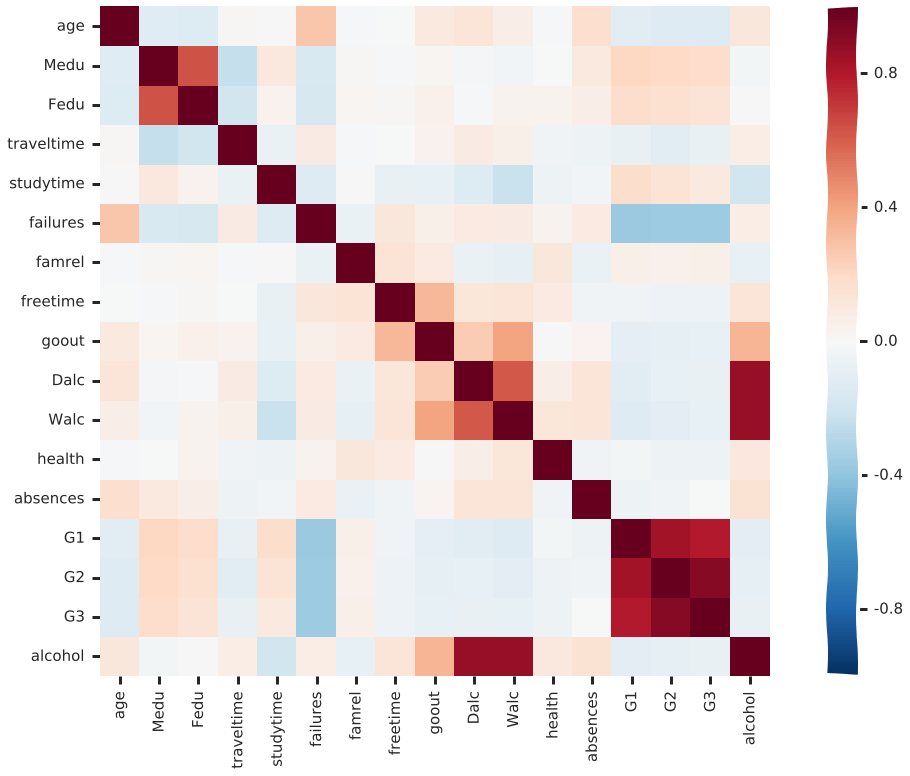

In [23]:
corr_mat = students_df.corr() 
fig, ax = plt.subplots(figsize=(20, 12)) 
sns.heatmap(corr_mat, vmax=1.0, square=True, ax=ax);


In [24]:
#Most of our variables are categorical and we must one-hot encode them four our NN to work properly.
def encode(series): 
  return pd.get_dummies(series.astype(str))

In [25]:
train_x = pd.get_dummies(students_df.school)
train_x['age'] = students_df.age
train_x['absences'] = students_df.absences
train_x['g1'] = students_df.G1
train_x['g2'] = students_df.G2
train_x['g3'] = students_df.G3
train_x = pd.concat([train_x, encode(students_df.sex), encode(students_df.Pstatus), 
                     encode(students_df.Medu), encode(students_df.Fedu),
                     encode(students_df.guardian), encode(students_df.studytime),
                     encode(students_df.failures), encode(students_df.activities),
                     encode(students_df.higher), encode(students_df.romantic),
                     encode(students_df.reason), encode(students_df.paid),
                     encode(students_df.goout), encode(students_df.health),
                     encode(students_df.famsize), encode(students_df.course)
                    ], axis=1)

train_y = encode(students_df.drinker)

In [26]:
train_size = 0.9

train_cnt = floor(train_x.shape[0] * train_size)
x_train = train_x.iloc[0:train_cnt].values
y_train = train_y.iloc[0:train_cnt].values
x_test = train_x.iloc[train_cnt:].values
y_test = train_y.iloc[train_cnt:].values

In [27]:
def multilayer_perceptron(x, weights, biases, keep_prob):
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_1 = tf.nn.dropout(layer_1, keep_prob)
    out_layer = tf.matmul(layer_1, weights['out']) + biases['out']
    return out_layer

In [28]:
n_hidden_1 = 38
n_input = train_x.shape[1]
n_classes = train_y.shape[1]

weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'out': tf.Variable(tf.random_normal([n_hidden_1, n_classes]))
}

biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

keep_prob = tf.placeholder("float")

In [29]:
training_epochs = 5000
display_step = 1000
batch_size = 32

x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_classes])

In [31]:
predictions = multilayer_perceptron(x, weights, biases, keep_prob)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=predictions, labels=y))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [32]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost)


In [33]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(training_epochs):
        avg_cost = 0.0
        total_batch = int(len(x_train) / batch_size)
        x_batches = np.array_split(x_train, total_batch)
        y_batches = np.array_split(y_train, total_batch)
        for i in range(total_batch):
            batch_x, batch_y = x_batches[i], y_batches[i]
            _, c = sess.run([optimizer, cost], 
                            feed_dict={
                                x: batch_x, 
                                y: batch_y, 
                                keep_prob: 0.8
                            })
            avg_cost += c / total_batch
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost=", \
                "{:.9f}".format(avg_cost))
    print("Optimization Finished!")
    correct_prediction = tf.equal(tf.argmax(predictions, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print("Accuracy:", accuracy.eval({x: x_test, y: y_test, keep_prob: 1.0}))

Epoch: 0001 cost= 54.621643490
Epoch: 1001 cost= 1.812319616
Epoch: 2001 cost= 0.404655716
Epoch: 3001 cost= 0.317146943
Epoch: 4001 cost= 0.229069808
Optimization Finished!
Accuracy: 0.7761194
